# ONLINE LEARNING

### What is Online Learning ?

Online learning is a machine learning method in which data becomes available in a sequential order and is used to update the best predictor for future data at each step, as opposed to batch learning which must be trained using all the available data and it's incapable of learning incrementally. 

Machine learning models are usually static things. They are essentially collections of parameters, after you've trained a model its parameters don't change (horizontal scalability). But what about new data? If we just train a model once and never touch it again, we’re missing out the information more data could provide us. This is especially important in environments where behaviours change quickly.

In online learning, you train the system incrementally by feeding it data instances sequentially, either individually or in small groups called mini-batches. Each learning step is fast and cheap, so the system can learn about new data on the fly, as it arrives.

One important parameter of online learning systems is how fast they should adapt to changing data (**Learning Rate**). If you set a high learning rate, then your system will rapidly adapt to new data, but it also tends to quickly forget the old data. On the other hand, if you set a low learning rate, the system will have more inertia, it will learn more slowly but it will also be less sensitive to noise in the new data or outliers.

### Why Online Learning ?

Online learning is a great method essentially in three main cases:
* **Continuos Flow**: Systems that receive data as a continuous flow, for example stock prices, and need to adapt to change rapidly or autonomously.


* **Limited Computing Resources**: Once an online learning system has learned about new data instances, it doesn't need them anymore, so you can discard them and this can save a huge amount of space.


* **Huge Datasets**: Can also be used to train systems on huge datasets that cannot fit in one machine's main memory. The algorithm loads part of the data, runs a training step on that data and repeats the process until it has run on all of the data.

### Project and Dataset Description

The purpose of this project is to show the implementation of the main machine learning models in the online learning mode and compare the results with the classical batch learning methods. 

We'll use the wine quality dataset from [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/wine+quality) which is public available for research. The dataset is related to white variant of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price). The inputs include objective tests (e.g. PH values) and the output is based on sensory data (median of at least 3 evaluations made by wine experts). Each expert graded the wine quality between 0 (very bad) and 10 (very excellent).

Some technical information about the dataset: 
* **Number of Instances**: 4898
* **Number of Attributes**: 11 + output attribute
* **Missing Attribute Values**: None
* **Input Variables** (based on physicochemical tests):
    1. fixed acidity 
    2. volatile acidity
    3. citric acid
    4. residual sugar
    5. chlorides
    6. free sulfur dioxide
    7. total sulfur dioxide
    8. density
    9. pH
    10. sulphates
    11. alcohol
    
    
* **Output Variable** (based on sensory data): 
    1. quality (score between 0 and 10) 
    
Applying online learning methods we'll simulate a continuos data flow, a pure streaming context where the observations arrive one by one (mini-batch learning is supported as well), and then we'll apply the same ML models in a batch learning mode without any kind of data manipulation or data cleaning to compare the online and batch learning methods on the exact same data.

### Libraries: River and Scikit-Learn

**River** is a Python library for online machine learning. It is the result of a merger between creme and scikit-multiflow for doing machine learning on streaming data.

Here are some benefits of using River (and online machine learning in general):
* **Incremental**: models can update themselves in real-time.
* **Adaptive**: models can adapt to concept drift.
* **Production-ready**: working with data streams makes it simple to replicate production scenarios during model development.
* **Efficient**: models don't have to be retrained and require little compute power, which lowers their carbon footprint
* **Fast**: when the goal is to learn and predict with a single instance at a time, then River is an order of magnitude faster than PyTorch, Tensorflow, and Scikit-learn.

**Scikit-learn** does not treat incremental learning as a 'first-class citizen', only a few online learning implementations are included in the library, there are only 5 algorithm available for classification tasks in the online learning mode. In river we can implement linear models with a wide array of optimizers, nearest neighbors, decision trees, naive bayes and much more in a super fast way. Anyway in Scikit-learn there are some algorithms that aren't yet present in the river library (e.g. SGDClassifier).

In this project we'll use the River and Scikit-learn libraries for applying these fundamental models in a multiclass classification task:
* **Logistic Regression** (River)
* **Adaptive Random Forest Classifier** (River)
* **Gaussian Naive Bayes** (River)
* **Softmax Regression** (River)
* **K-Nearest Neighbors** (River)
* **SGDClassifier(SVM)** (Scikit-learn)

### Preparing the Data for the Online Learning 

In [184]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from river import stream, optim, evaluate
from river.linear_model import LogisticRegression, SoftmaxRegression
from river.ensemble import AdaptiveRandomForestClassifier
from river.naive_bayes import GaussianNB
from river.neighbors import KNNClassifier
from river.multiclass import OneVsRestClassifier
from river.preprocessing import StandardScaler
from river.compose import Pipeline
from river.metrics import Accuracy
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [148]:
#Getting the dataframe
df = pd.read_csv('winequality-white.csv')
#Shuffling the rows
df = shuffle(df, random_state=11).reset_index(drop=True)
#Saving the dataframe
df.to_csv("winequality-white-shuffled.csv", index=False)

In river, the features of a sample are stored inside a dictionary, which in Python is called a dict and is a native data structure. In other words, we don't use any sophisticated data structure, such as a *numpy.ndarray* or a *pandas.DataFrame*.

The main advantage of using plain dicts is that it removes the overhead that comes with using the aforementioned data structures. This is important in a streaming context because we want to be able to process many individual samples in rapid succession.

Another advantage is that dicts play nicely with Python's standard library. Indeed, Python contains many tools that allow manipulating dicts. For instance, the *csv.DictReader* can be used to read a CSV file and convert each row to a dict. In fact, the *stream.iter_csv* method from river is just a wrapper on top of *csv.DictReader* that adds a few features.

In [149]:
# Construct our data dictionary which maps the data types of the columns in the CSV file to built-in data types
print("[INFO] building column names...")
types = {'fixed acidity':float, 'volatile acidity':float, 'citric acid':float, 'residual sugar':float, 'chlorides':float,
         'free sulfur dioxide':float, 'total sulfur dioxide':float, 'density':float, 'pH':float, 'sulphates':float,
         'alcohol':float}
types["quality"] = int

[INFO] building column names...


Not all classifiers support multi-class classification, each classifier in river inherits from the *base.Classifier* class. Each classifier therefore has a *_multiclass* property which indicates whether or not it can process a non-boolean target value. The *multiclass* module contains wrapper models that enable you to perform multi-class classification with binary classifiers.

Let's check which models support a multiclass classification task. If a model doesn't support it, we can use a River class of the *multiclass* module (*OneVsRestClassifier*) as a wrapper.

In [194]:
#Checking multi-class support for all the models
models = [LogisticRegression(), AdaptiveRandomForestClassifier(), GaussianNB(), SoftmaxRegression(), KNNClassifier()]

for model in models:
    #This differentiation must be made because for some models '_multiclass' is a property for others is a static method     
    try:
        print('{} support multiclass: {}'.format(model, model._multiclass()))
    except:
        print('{} support multiclass: {}'.format(model, model._multiclass))

#In Scikit-learn the SGDClassifier support multiclass as OneVsRest 
print('SGDClassifier support multiclass: True')

LogisticRegression support multiclass: False
AdaptiveRandomForestClassifier support multiclass: True
GaussianNB support multiclass: True
SoftmaxRegression support multiclass: True
KNNClassifier support multiclass: True
SGDClassifier support multiclass: True


LogisticRegression is the only model that doesn't support multiclass classification but we can use the *OneVsRestClassifier* class as a wrapper.

## Logistic Regression         

In [157]:
learning_rates = [0.001, 0.003, 0.005, 0.01]
losses = [(optim.losses.Log(), 'Log'), (optim.losses.Hinge(), 'Hinge')]

log_accuracies = []
hinge_accuracies = []

for rate in learning_rates:
    for loss in losses:
        
        #Getting the dataset
        #It's necessary to reload the dataset every cycle because it was previously emptied by simulating a stream line by line
        dataset = stream.iter_csv("winequality-white-shuffled.csv", target="quality", converters=types)
        
        #Constructing our pipeline (standardize features + model)
        model = (
            StandardScaler() | 
            OneVsRestClassifier(classifier=LogisticRegression(intercept_lr = rate, loss=loss[0]))
        )

        #Initializing our metric
        print("[INFO] starting training...   [Parameters: learning rate = {}, loss = {}]".format(rate, loss[1]))
        metric = Accuracy()
        
        #Looping over the dataset one row at a time
        evaluate.progressive_val_score(dataset, model, metric)
    
        #Saving the results as raw numbers
        if loss[1] == 'Log':
            log_accuracies.append(float(str(metric).split(':')[1].strip()[:-1]))
        else:
            hinge_accuracies.append(float(str(metric).split(':')[1].strip()[:-1]))
            
        #Showing the accuracy of the model    
        print("[INFO] final - {}".format(metric))

[INFO] starting training...   [Parameters: learning rate = 0.001, loss = Log]
[INFO] final - Accuracy: 49.64%
[INFO] starting training...   [Parameters: learning rate = 0.001, loss = Hinge]
[INFO] final - Accuracy: 49.38%
[INFO] starting training...   [Parameters: learning rate = 0.003, loss = Log]
[INFO] final - Accuracy: 50.44%
[INFO] starting training...   [Parameters: learning rate = 0.003, loss = Hinge]
[INFO] final - Accuracy: 49.70%
[INFO] starting training...   [Parameters: learning rate = 0.005, loss = Log]
[INFO] final - Accuracy: 51.03%
[INFO] starting training...   [Parameters: learning rate = 0.005, loss = Hinge]
[INFO] final - Accuracy: 49.38%
[INFO] starting training...   [Parameters: learning rate = 0.01, loss = Log]
[INFO] final - Accuracy: 50.60%
[INFO] starting training...   [Parameters: learning rate = 0.01, loss = Hinge]
[INFO] final - Accuracy: 49.44%


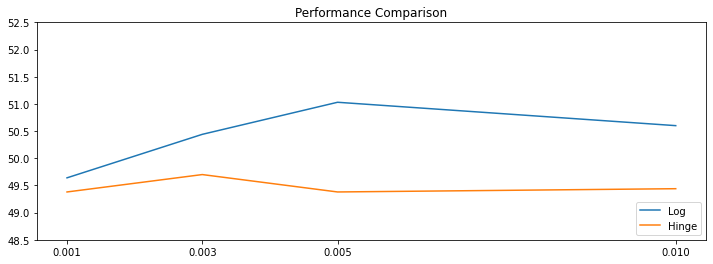

In [158]:
#Plotting the results
plt.figure(figsize=(12,4))
x = [0.001, 0.003, 0.005, 0.01]
log = plt.plot(x, log_accuracies, label = "Log")
hinge = plt.plot(x, hinge_accuracies, label = "Hinge")
plt.xticks(x)
plt.yticks(np.arange(48.5, 53, 0.5))
plt.title("Performance Comparison")
plt.legend(handles=[log[0], hinge[0]], loc= "lower right")
plt.show()  

The combination of parameters *loss = Log* and *intercept_lr = 0.005* returns the better performance. Let's see how the model performance change as the data arrives.

In [159]:
#Getting the dataset
dataset = stream.iter_csv("winequality-white-shuffled.csv", target="quality", converters=types)

#Constructing our pipeline (standardize features + model)
model = Pipeline(
    StandardScaler(),
    OneVsRestClassifier(classifier=LogisticRegression(loss = optim.losses.Log(), intercept_lr = 0.005)))

#Initializing our metric
print("[INFO] starting training...")
metric = Accuracy()

values = []

#Looping over the dataset one row at a time
for (i, (X, y)) in enumerate(dataset):
    #Make predictions on the current set of features, train the
    #model on the features, and then update our metric
    preds = model.predict_one(X)
    model = model.learn_one(X, y)
    metric = metric.update(y, preds)
    values.append((i, float(str(metric).split(':')[1].strip()[:-1])))
    #print("[INFO] update {} - {}".format(i, metric))
    
#Showing the accuracy of the model
print("[INFO] final - {}".format(metric))

[INFO] starting training...
[INFO] final - Accuracy: 51.02%


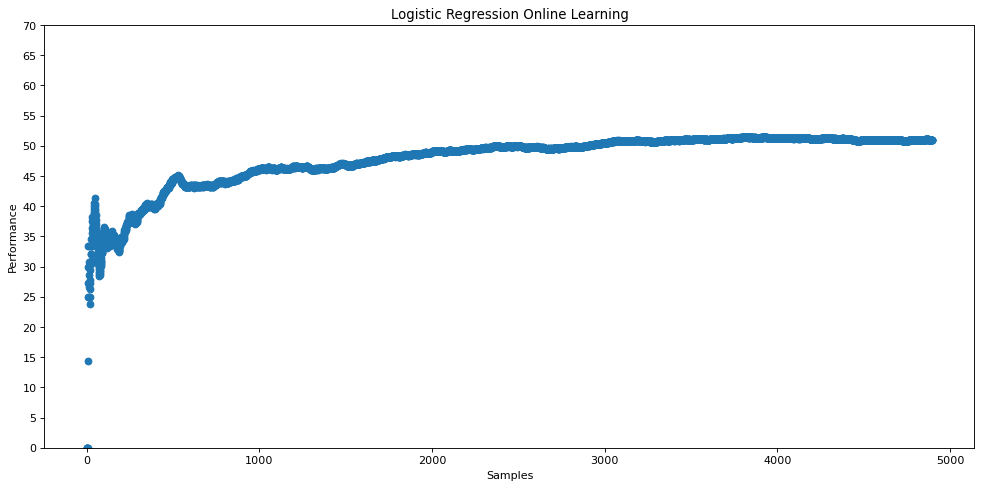

In [199]:
figure(figsize=(15, 7), dpi=80)
ax = plt.gca()
plt.yticks(np.arange(0, 101, 5))
ax.set_ylim([0, 70])
plt.title("Logistic Regression Online Learning")
plt.xlabel("Samples")
plt.ylabel("Performance")
plt.scatter(*zip(*values))
plt.show()

## Adaptive Random Forest Classifier

In [ ]:
#Getting the dataset
dataset = stream.iter_csv("winequality-white.csv", target="quality", converters=types)

In [ ]:
model = AdaptiveRandomForestClassifier(n_models=3, seed=42)

print("[INFO] starting training...")
metric = Accuracy()

values = []

# loop over the dataset
for (i, (X, y)) in enumerate(dataset):
    # make predictions on the current set of features, train the
    # model on the features, and then update our metric
    preds = model.predict_one(X)
    model = model.learn_one(X, y)
    metric = metric.update(y, preds)
    values.append((i, float(str(metric).split(':')[1].strip()[:-1])))
    print("[INFO] update {} - {}".format(i, metric))
    
# show the accuracy of the model
print("[INFO] final - {}".format(metric))

In [ ]:
figure(figsize=(15, 15), dpi=80)
ax = plt.gca()
ax.set_ylim([0, 100])
plt.scatter(*zip(*values))
plt.show()

# GAUSSIAN NAIVE BAYES (42.26%)

In [ ]:
#It is necessary to reload the dataset because it was previously emptied by simulating a stream line by line
dataset = stream.iter_csv("winequality-white.csv", target="quality", converters=types)

In [ ]:
model = GaussianNB()
model._multiclass

In [ ]:
print("[INFO] starting training...")
metric = Accuracy()

values = []

# loop over the dataset
for (i, (X, y)) in enumerate(dataset):
    # make predictions on the current set of features, train the
    # model on the features, and then update our metric
    preds = model.predict_one(X)
    model = model.learn_one(X, y)
    metric = metric.update(y, preds)
    values.append((i, float(str(metric).split(':')[1].strip()[:-1])))
    print("[INFO] update {} - {}".format(i, metric))
    
# show the accuracy of the model
print("[INFO] final - {}".format(metric))

In [ ]:
figure(figsize=(15, 15), dpi=80)
ax = plt.gca()
ax.set_ylim([0, 100])
plt.scatter(*zip(*values))
plt.show()

# SOFTMAX REGRESSION (42.71%)

In [ ]:
#It is necessary to reload the dataset because it was previously emptied by simulating a stream line by line
dataset = stream.iter_csv("winequality-white.csv", target="quality", converters=types)

In [ ]:
model = SoftmaxRegression()
model._multiclass

In [ ]:
print("[INFO] starting training...")
metric = Accuracy()

values = []

# loop over the dataset
for (i, (X, y)) in enumerate(dataset):
    # make predictions on the current set of features, train the
    # model on the features, and then update our metric
    preds = model.predict_one(X)
    model = model.learn_one(X, y)
    metric = metric.update(y, preds)
    values.append((i, float(str(metric).split(':')[1].strip()[:-1])))
    print("[INFO] update {} - {}".format(i, metric))
    
# show the accuracy of the model
print("[INFO] final - {}".format(metric))

In [ ]:
figure(figsize=(15, 15), dpi=80)
ax = plt.gca()
ax.set_ylim([0, 100])
plt.scatter(*zip(*values))
plt.show()

# K-NEAREST NEIGHBORS (53.27%)

In [ ]:
#It is necessary to reload the dataset because it was previously emptied by simulating a stream line by line
dataset = stream.iter_csv("winequality-white.csv", target="quality", converters=types)

In [ ]:
model = KNNClassifier()
model._multiclass

In [ ]:
print("[INFO] starting training...")
metric = Accuracy()

values = []

# loop over the dataset
for (i, (X, y)) in enumerate(dataset):
    # make predictions on the current set of features, train the
    # model on the features, and then update our metric
    preds = model.predict_one(X)
    model = model.learn_one(X, y)
    metric = metric.update(y, preds)
    values.append((i, float(str(metric).split(':')[1].strip()[:-1])))
    print("[INFO] update {} - {}".format(i, metric))
    
# show the accuracy of the model
print("[INFO] final - {}".format(metric))

In [ ]:
figure(figsize=(15, 15), dpi=80)
ax = plt.gca()
ax.set_ylim([0, 100])
plt.scatter(*zip(*values))
plt.show()

# SVM - SGDCLASSIFIER (42.13%)

In [ ]:
chunksize = 1
model = SGDClassifier(loss='hinge', penalty="l2")

features_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
                    'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates','alcohol']

def acc(try_n, accuracy_score):
    return accuracy_score/try_n*100
    
data = pd.read_csv("winequality-white.csv")
print(np.unique(data['quality']))

tent = 0
acc_cumul_score = 0
values = []

for df in pd.read_csv("winequality-white.csv", chunksize=chunksize, iterator=True):
    if tent == 0:
        X = df[features_columns]
        y = df['quality']
        model.partial_fit(X, y, classes=np.unique(data['quality']))
        predictions = model.predict(X)
        accuracy = accuracy_score(y, predictions)
        acc_cumul_score += accuracy
        tent += 1
        values.append((tent, acc(tent, acc_cumul_score)))
        print('Accuracy: {}'.format(acc(tent, acc_cumul_score)))

    else:
        X = df[features_columns]
        y = df['quality']
        predictions = model.predict(X)
        model.partial_fit(X, y)
        accuracy = accuracy_score(y, predictions)
        acc_cumul_score += accuracy
        tent += 1
        values.append((tent, acc(tent, acc_cumul_score)))
        print('Accuracy[{}]: {}'.format(tent, acc(tent, acc_cumul_score)))

In [ ]:
figure(figsize=(15, 15), dpi=80)
ax = plt.gca()
ax.set_ylim([0, 100])
plt.scatter(*zip(*values))
plt.show()